In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json

from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import log_loss, accuracy_score
from sklearn.model_selection import StratifiedKFold

import optuna

import lightgbm as lgb

In [132]:
df = pd.DataFrame()

l = ["data-2015.csv","data-2016.csv","data-2017.csv","data-2018.csv","data-2019.csv","data-2020.csv","data-2021.csv"]
for data in l:
    df_csv = pd.read_csv(f"data/{data}")
    df = pd.concat([df, df_csv])
df.index = np.arange(len(df))

C:\Users\raves\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (98) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
C:\Users\raves\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (95,96,98) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
C:\Users\raves\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (33,34,44,45,48,95) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [277]:
list(df)

['num',
 'nom',
 'classement',
 'id',
 'date',
 'url',
 'tpsLastRace',
 'last_race_dist',
 'fer',
 'firstTimeFer',
 'sex',
 'age_x',
 'dist',
 'driver_x',
 'trainer',
 'avisTrainer',
 'music',
 'nbArrivé',
 'lastPerf',
 'meanPerf',
 'medianPerf',
 'modePerf',
 'recordAbs',
 'gain',
 'numPmu',
 'age_y',
 'sexe',
 'race',
 'statut',
 'oeilleres',
 'proprietaire',
 'entraineur',
 'driver_y',
 'driverChange',
 'indicateurInedit',
 'musique',
 'nombreCourses',
 'nombreVictoires',
 'nombrePlaces',
 'nombrePlacesSecond',
 'nombrePlacesTroisieme',
 'nomPere',
 'nomMere',
 'ordreArrivee',
 'jumentPleine',
 'engagement',
 'supplement',
 'handicapDistance',
 'poidsConditionMonteChange',
 'tempsObtenu',
 'reductionKilometrique',
 'urlCasaque',
 'eleveur',
 'allure',
 'robe_code',
 'robe_libelleCourt',
 'robe_libelleLong',
 'gainsParticipant_gainsCarriere',
 'gainsParticipant_gainsVictoires',
 'gainsParticipant_gainsPlace',
 'gainsParticipant_gainsAnneeEnCours',
 'gainsParticipant_gainsAnneePrecede

In [171]:
list(df)

['num',
 'nom',
 'classement',
 'id',
 'date',
 'url',
 'tpsLastRace',
 'last_race_dist',
 'fer',
 'firstTimeFer',
 'sex',
 'age_x',
 'dist',
 'driver_x',
 'trainer',
 'avisTrainer',
 'music',
 'nbArrivé',
 'lastPerf',
 'meanPerf',
 'medianPerf',
 'modePerf',
 'recordAbs',
 'gain',
 'numPmu',
 'age_y',
 'sexe',
 'race',
 'statut',
 'oeilleres',
 'proprietaire',
 'entraineur',
 'deferre',
 'driver_y',
 'driverChange',
 'indicateurInedit',
 'musique',
 'nombreCourses',
 'nombreVictoires',
 'nombrePlaces',
 'nomPere',
 'nomMere',
 'jumentPleine',
 'engagement',
 'supplement',
 'handicapDistance',
 'poidsConditionMonteChange',
 'urlCasaque',
 'allure',
 'robe_code',
 'robe_libelleCourt',
 'robe_libelleLong',
 'gainsParticipant_gainsCarriere',
 'gainsParticipant_gainsVictoires',
 'gainsParticipant_gainsPlace',
 'gainsParticipant_gainsAnneeEnCours',
 'gainsParticipant_gainsAnneePrecedente',
 'dernierRapportDirect_typePari',
 'dernierRapportDirect_rapport',
 'dernierRapportDirect_typeRapport'

In [282]:
df["nbArrivé"]

0        11
1         7
2        12
3        12
4        11
         ..
87686    11
87687    12
87688    12
87689    11
87690     8
Name: nbArrivé, Length: 87691, dtype: int64

In [255]:
for i in range(1,3):
    df[f"M{i}"] = pd.to_numeric(df["music"].apply(lambda x: x.strip("[]").split(", ")[i])).replace(0,10)

In [257]:
df["M1"].unique()

array([ 3,  7,  1,  2, 10,  4,  6,  8,  9,  5], dtype=int64)

In [196]:
features = ['num',
            'id',
 'tpsLastRace',
 'last_race_dist',
 'fer',
 'firstTimeFer',
 'sex',
 'age_x',
 'dist',
 'avisTrainer',
 'lastPerf',
 'meanPerf',
 'medianPerf',
 'modePerf',
 'recordAbs',
 'gain',
 'nombreCourses',
 'nombreVictoires',
 'nombrePlaces',
 'nombrePlacesSecond',
 'nombrePlacesTroisieme',
 'handicapDistance',
 'gainsParticipant_gainsPlace',
 "dernierRapportReference_indicateurTendance",
 'gainsParticipant_gainsAnneeEnCours',
 'gainsParticipant_gainsAnneePrecedente',
 'dernierRapportReference_rapport',
 'nbCourseCouple',
 'nbVictoiresCouple',
 'nb2emeCouple',
 'nb3emeCouple',
 'txReussiteCouple']

In [167]:
len(features)

31

In [178]:
df_train = df.loc[:][features].apply(pd.to_numeric, errors="coerce")
y = df["classement"].replace(['DA', 'D1', 'A ',
       'D7', 'D8', 'H8', 'T ', 'G ', 'D5', 'D6', 'D', 'D3', 'D4', 'D2', 'D ',
       'G5', 'D9', 'H9', 'G4', 'R8', 'G6'], 10)

y = pd.to_numeric(y,downcast="integer",errors='coerce').fillna(10).replace(0,10).astype(np.int32)

ids = df.loc[:]["id"]
# df_train["dernierRapportReference_indicateurTendance"] = df_train["dernierRapportReference_indicateurTendance"].replace(["+", " ", "-"], [1, 0, -1]).fillna(0)


In [195]:
gss = GroupShuffleSplit(test_size=.40, n_splits=2, random_state = 7)

gss2 = GroupShuffleSplit(test_size=.40, n_splits=1, random_state = 7).split(df_train, y, groups=ids)

X_train_inds, X_test_inds = next(gss2)

train_data= df_train.iloc[X_train_inds]
X_train = train_data.loc[:, ~train_data.columns.isin(['id'])]
y_train = y.iloc[X_train_inds]

groups = train_data.groupby('id').size().to_frame('size')['size'].to_numpy()

test_data = df_train.loc[:].iloc[X_test_inds]

#We need to keep the id for later predictions
X_test = test_data.loc[:, ~test_data.columns.isin(['id'])]
y_test = y.iloc[X_test_inds]

test_groups = test_data.groupby('id').size().to_frame('size')['size'].to_numpy()

In [180]:
gss.get_n_splits()

2

In [170]:
for train_idx, test_idx in gss.split(df_train,y, groups=ids):
    print("TRAIN:", train_idx, "TEST:", test_idx)

TRAIN: [    36     37     38 ... 144161 144162 144163] TEST: [     0      1      2 ... 144145 144146 144147]
TRAIN: [     0      1      2 ... 144145 144146 144147] TEST: [    49     50     51 ... 144161 144162 144163]


# Hyperparameter

In [183]:
from optuna.integration import LightGBMPruningCallback
from scipy import stats
import sklearn.metrics

def objective(trial):
    param_grid = {
    "n_estimators": trial.suggest_int("n_estimators", 100,2000),
    "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),
    "num_leaves": trial.suggest_int("num_leaves", 20, 3000),
    "max_depth": trial.suggest_int("max_depth", -1, 500),
    "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 10000),
    }
    model = lgb.LGBMRanker(n_jobs=24,objective="lambdarank",boosting_type = "dart",metric= "ndcg", **param_grid)
    
    scores = []
    
    for X_train_inds, X_test_inds in gss.split(df_train,y, groups=ids):
        train_data = df_train.iloc[X_train_inds]
        X_train = train_data.loc[:, ~train_data.columns.isin(['id'])]
        y_train = y.iloc[X_train_inds]
        groups = train_data.groupby('id').size().to_frame('size')['size'].to_numpy()
        
        test_data = df_train.iloc[X_test_inds]
        X_test = test_data.loc[:, ~test_data.columns.isin(['id'])]
        y_test = y.iloc[X_test_inds]
        test_groups = test_data.groupby('id').size().to_frame('size')['size'].to_numpy()
        
        model.fit(
            X_train,
            y_train,
            group = groups,
        )
        
        preds = model.predict(X_test)
        test_data["rank_pred"] = preds
        test_data['rank_pred'] = test_data.groupby("id")["rank_pred"].rank("dense",ascending=True).astype(int)
        test_data['rank_pred'] = test_data.groupby("id")["rank_pred"].rank("first").astype(int)

        test_data["classement"] = y_test
        corr_coef = test_data[["classement", "rank_pred"]].corr(method="spearman")["classement"].loc["rank_pred"]
        preds_percentage = len(test_data.loc[test_data["rank_pred"] == 1].loc[test_data["classement"] == 1]) / len(test_data.groupby("id"))

        scores.append(corr_coef * preds_percentage)
        
    return np.mean(scores)

In [184]:
study = optuna.create_study(direction="maximize", study_name="LGBM Ranker")
func = lambda trial: objective(trial)
study.optimize(func, n_trials=2)

[I 2022-11-14 21:44:37,430] A new study created in memory with name: LGBM Ranker


[LightGBM] [Warning] min_data_in_leaf is set=790, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=790


<ipython-input-183-c980ee84ff75>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data["rank_pred"] = preds
<ipython-input-183-c980ee84ff75>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['rank_pred'] = test_data.groupby("id")["rank_pred"].rank("dense",ascending=True).astype(int)
<ipython-input-183-c980ee84ff75>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

[LightGBM] [Warning] min_data_in_leaf is set=790, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=790


<ipython-input-183-c980ee84ff75>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data["rank_pred"] = preds
<ipython-input-183-c980ee84ff75>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['rank_pred'] = test_data.groupby("id")["rank_pred"].rank("dense",ascending=True).astype(int)
<ipython-input-183-c980ee84ff75>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

[LightGBM] [Warning] min_data_in_leaf is set=2844, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2844


<ipython-input-183-c980ee84ff75>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data["rank_pred"] = preds
<ipython-input-183-c980ee84ff75>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['rank_pred'] = test_data.groupby("id")["rank_pred"].rank("dense",ascending=True).astype(int)
<ipython-input-183-c980ee84ff75>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

[LightGBM] [Warning] min_data_in_leaf is set=2844, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2844


<ipython-input-183-c980ee84ff75>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data["rank_pred"] = preds
<ipython-input-183-c980ee84ff75>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['rank_pred'] = test_data.groupby("id")["rank_pred"].rank("dense",ascending=True).astype(int)
<ipython-input-183-c980ee84ff75>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

In [185]:
print('Number of finished trials:', len(study.trials))
print('Best Correlation', study.best_value)
print('Best trial:', study.best_trial.params)

Number of finished trials: 2
Best Correlation 0.18138638604081847
Best trial: {'n_estimators': 1894, 'learning_rate': 0.015482062204812644, 'num_leaves': 2839, 'max_depth': 403, 'min_data_in_leaf': 2844}


In [42]:
params = {'n_estimators': 300, 'learning_rate': 0.03044996692992604, 'num_leaves': 2960, 'max_depth': 349, 'min_data_in_leaf': 200}

In [186]:
gbm = lgb.LGBMRanker(objective="lambdarank",
                    boosting_type = "dart",
                    importance_type = "split",
                    n_jobs=24,
                    metric= "ndcg",
                    **study.best_trial.params)

In [197]:
gbm.fit(X_train, y_train, group=groups)

[LightGBM] [Warning] min_data_in_leaf is set=2844, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2844


LGBMRanker(boosting_type='dart', learning_rate=0.015482062204812644,
           max_depth=403, metric='ndcg', min_data_in_leaf=2844,
           n_estimators=1894, n_jobs=24, num_leaves=2839,
           objective='lambdarank')

In [198]:
list(test_data)

['num',
 'id',
 'tpsLastRace',
 'last_race_dist',
 'fer',
 'firstTimeFer',
 'sex',
 'age_x',
 'dist',
 'avisTrainer',
 'lastPerf',
 'meanPerf',
 'medianPerf',
 'modePerf',
 'recordAbs',
 'gain',
 'nombreCourses',
 'nombreVictoires',
 'nombrePlaces',
 'nombrePlacesSecond',
 'nombrePlacesTroisieme',
 'handicapDistance',
 'gainsParticipant_gainsPlace',
 'dernierRapportReference_indicateurTendance',
 'gainsParticipant_gainsAnneeEnCours',
 'gainsParticipant_gainsAnneePrecedente',
 'dernierRapportReference_rapport',
 'nbCourseCouple',
 'nbVictoiresCouple',
 'nb2emeCouple',
 'nb3emeCouple',
 'txReussiteCouple']

In [200]:
predictions = gbm.predict(X_test)
test_data["rank_pred"] = predictions
test_data['rank_pred'] = test_data.groupby("id")["rank_pred"].rank("dense",ascending=True).astype(int)
test_data['rank_pred'] = test_data.groupby("id")["rank_pred"].rank("first").astype(int)

test_data["classement"] = y_test

In [201]:
test_data[["classement", "rank_pred"]].corr(method="spearman")["classement"].loc["rank_pred"]

0.5490476795441201

In [203]:
len(test_data.loc[test_data["rank_pred"] == 1].loc[test_data["classement"] == 1]) / len(test_data.groupby("id"))

0.33726528647087145

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

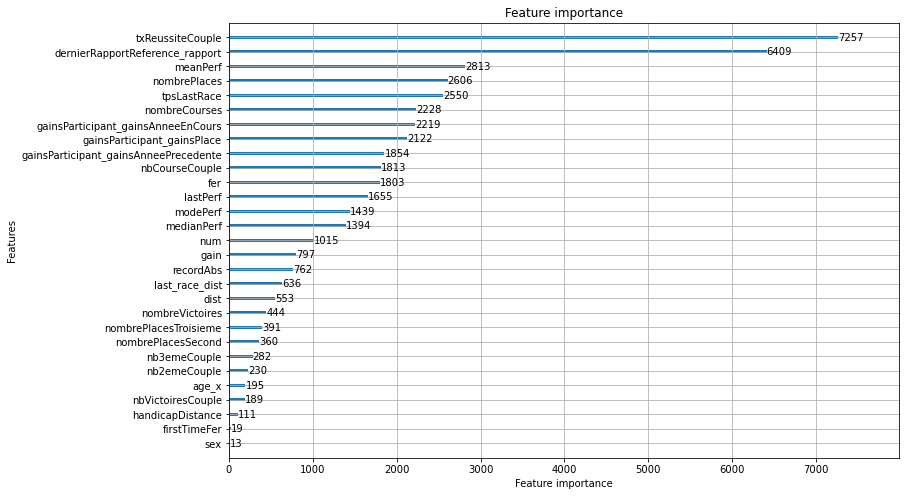

In [204]:
lgb.plot_importance(gbm, figsize = (12,8))

In [205]:
gbm.booster_.save_model("models/model_non_overfitted.txt")

In [75]:
def get_proba(rapport_min,rapport_max):
    p = len(test_data.loc[test_data["dernierRapportReference_rapport"] <= rapport_max].loc[test_data["dernierRapportReference_rapport"] >= rapport_min].loc[test_data["rank_pred"] == 1].loc[test_data["classement"]==1]) / len(test_data.loc[test_data["dernierRapportReference_rapport"] <= rapport_max].loc[test_data["dernierRapportReference_rapport"] > rapport_min].loc[test_data["rank_pred"] == 1])
    return p

In [95]:
get_proba(4,5)

KeyError: 'dernierRapportReference_rapport'

In [25]:
class_rapport = np.arange(5,50,5)
nb_victoire = []
for i in class_rapport:
    nb_victoire.append( len(test_data.loc[test_data["rank_pred"] == 1].loc[test_data["classement"] == 1].loc[test_data["dernierRapportDirect_rapport"] < i ]) - sum(nb_victoire))

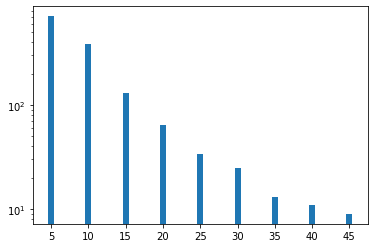

In [56]:
plt.bar(class_rapport,nb_victoire)
plt.yscale("log")

In [27]:
test_data.loc[test_data["rank_pred"] == 1].loc[test_data["classement"] == 1].dernierRapportDirect_rapport.describe()

count    1403.00000
mean        8.29943
std        11.00954
min         1.10000
25%         3.00000
50%         4.90000
75%         8.90000
max       165.00000
Name: dernierRapportDirect_rapport, dtype: float64

In [370]:
argent = 100
wins, loses = 0, 0

evo = [100]
for name,group in test_data.groupby("id"):
    cote = group.loc[group["rank_pred"] == 1]["dernierRapportDirect_rapport"].values[0]
    
    if not np.isnan(cote):
        f_kelly = kelly(cote, argent, get_proba(cote-5,cote+5))
        if group.loc[group["rank_pred"] == 1]["classement"].values[0] == 1:
            argent += cote * f_kelly*argent
            wins+=1
        else:
            argent -= f_kelly*argent
            loses +=1
        evo += [argent]

<ipython-input-370-209bb6d4ee18>:11: RuntimeWarning: overflow encountered in double_scalars
  argent += cote * f_kelly*argent
<ipython-input-370-209bb6d4ee18>:14: RuntimeWarning: invalid value encountered in double_scalars
  argent -= f_kelly*argent


In [369]:
print(argent)
x = np.arange(len(evo))
a,b = np.polyfit(x, evo, 1)

nan


LinAlgError: SVD did not converge in Linear Least Squares

In [371]:
evo

[100,
 66.81869682945097,
 44.4097109273812,
 30.282347943507872,
 20.569448074122395,
 14.220341789332757,
 10.330751584373031,
 7.447531506561203,
 5.547032223660887,
 4.078491000345537,
 2.8493396668062863,
 2.1406705919217477,
 1.5264938702121595,
 0.9973610052746354,
 0.6689008351838851,
 0.45210729035045083,
 0.32397768567000845,
 0.5404775499737986,
 0.39264452208162176,
 1.3863533174128877,
 0.9066281332053002,
 0.666904988572487,
 1.0787132107328166,
 0.7776540320288818,
 0.559847679155752,
 4.798694392763587,
 3.3963109699935834,
 2.208069941924203,
 1.6053569730826478,
 1.2446643137563687,
 0.8724176038622028,
 10.955942001990454,
 8.054772790868164,
 5.9249961029297875,
 4.30437353648291,
 3.08449123996209,
 2.166107456667729,
 6.955008056977844,
 5.291944114909797,
 11.5481578244218,
 7.663045850861112,
 25.723405373827966,
 17.22514538117484,
 12.049335422836325,
 53.52847908563325,
 38.8915464826006,
 26.619274479809878,
 19.353299047820958,
 134.32111124856687,
 96.0449

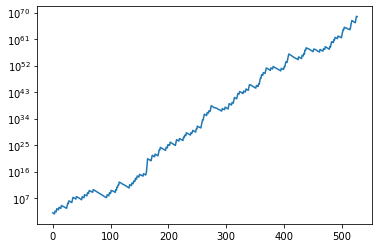

In [367]:
plt.plot(evo)
# plt.plot(a*x+b)
plt.yscale("log")

In [34]:
y_test

,classement
36,3
37,2
38,4
39,6
40,10
...,...
32687,5
32688,0
32689,10
32690,1


In [59]:
list(X_test)

35

In [207]:
features_pred = ['num',
 'tpsLastRace',
 'last_race_dist',
 'fer',
 'firstTimeFer',
 'sex',
 'age_x',
 'dist',
 'avisTrainer',
 'lastPerf',
 'meanPerf',
 'medianPerf',
 'modePerf',
 'recordAbs',
 'gain',
 'nombreCourses',
 'nombreVictoires',
 'nombrePlaces',
 'nombrePlacesSecond',
 'nombrePlacesTroisieme',
 'handicapDistance',
 'gainsParticipant_gainsPlace',
 "dernierRapportReference_indicateurTendance",
 'gainsParticipant_gainsAnneeEnCours',
 'gainsParticipant_gainsAnneePrecedente',
 'dernierRapportReference_rapport',
 'nbCourseCouple',
 'nbVictoiresCouple',
 'nb2emeCouple',
 'nb3emeCouple',
 'txReussiteCouple']

# Prédictions

In [2]:
loaded_model = lgb.Booster(model_file="models/modelv1.txt")

In [208]:
today = pd.read_csv("today.csv", index_col=0)
today_feat = today.loc[:][features_pred]
today_feat["dernierRapportReference_indicateurTendance"] = today_feat["dernierRapportReference_indicateurTendance"].replace(["+", " ", "-"], [1, 0, -1]).fillna(0)
today_feat = today_feat.apply(pd.to_numeric, errors="coerce")
today_feat

,num,tpsLastRace,last_race_dist,fer,firstTimeFer,sex,age_x,dist,avisTrainer,lastPerf,...,gainsParticipant_gainsPlace,dernierRapportReference_indicateurTendance,gainsParticipant_gainsAnneeEnCours,gainsParticipant_gainsAnneePrecedente,dernierRapportReference_rapport,nbCourseCouple,nbVictoiresCouple,nb2emeCouple,nb3emeCouple,txReussiteCouple
0,1.0,72,2800,3,False,1,7,2650,3,0,...,2090000.0,1.0,0.0,0.0,52.0,7,0,0,0,0
1,2.0,8,2725,2,False,1,7,2650,2,6,...,3857000.0,1.0,789000.0,987000.0,25.0,12,0,1,2,25
2,3.0,14,2725,3,False,1,7,2650,2,2,...,2622500.0,0.0,1023500.0,628000.0,2.5,10,2,2,2,60
3,4.0,14,2725,2,False,1,7,2650,2,5,...,2604000.0,0.0,1443000.0,417000.0,8.9,15,4,0,1,33
4,5.0,29,2650,3,False,1,8,2650,2,8,...,3887000.0,-1.0,476000.0,907000.0,16.0,9,0,0,1,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11,12.0,8,2875,3,False,1,6,2450,1,7,...,NaN,0.0,NaN,NaN,NaN,0,0,0,0,0
12,13.0,15,2825,0,False,1,6,2450,3,0,...,NaN,0.0,NaN,NaN,NaN,3,0,0,1,33
13,14.0,97,2725,0,False,1,6,2450,3,4,...,NaN,0.0,NaN,NaN,NaN,12,0,1,1,16
14,15.0,8,2875,0,False,1,6,2450,3,8,...,NaN,0.0,NaN,NaN,NaN,7,0,1,2,42


In [31]:
today.loc[today["numCoursePMU"] == "R10C3"]["dernierRapportDirect_rapport"]

0     29.5
1     61.1
2     67.3
3      6.3
4      3.8
5     68.7
6      7.7
7      6.5
8     41.1
9      5.0
10    31.3
11     8.0
Name: dernierRapportDirect_rapport, dtype: float64

In [151]:
list(today)

['num',
 'nom',
 'id',
 'date',
 'url',
 'tpsLastRace',
 'last_race_dist',
 'fer',
 'firstTimeFer',
 'sex',
 'age_x',
 'dist',
 'driver_x',
 'trainer',
 'avisTrainer',
 'music',
 'nbArrivé',
 'lastPerf',
 'meanPerf',
 'medianPerf',
 'modePerf',
 'recordAbs',
 'gain',
 'numPmu',
 'age_y',
 'sexe',
 'race',
 'statut',
 'oeilleres',
 'proprietaire',
 'entraineur',
 'driver_y',
 'driverChange',
 'indicateurInedit',
 'musique',
 'nombreCourses',
 'nombreVictoires',
 'nombrePlaces',
 'nombrePlacesSecond',
 'nombrePlacesTroisieme',
 'nomPere',
 'nomMere',
 'jumentPleine',
 'engagement',
 'supplement',
 'handicapDistance',
 'poidsConditionMonteChange',
 'urlCasaque',
 'eleveur',
 'allure',
 'avisEntraineur',
 'robe_code',
 'robe_libelleCourt',
 'robe_libelleLong',
 'gainsParticipant_gainsCarriere',
 'gainsParticipant_gainsVictoires',
 'gainsParticipant_gainsPlace',
 'gainsParticipant_gainsAnneeEnCours',
 'gainsParticipant_gainsAnneePrecedente',
 'dernierRapportDirect_typePari',
 'dernierRappor

In [209]:
pred_today = gbm.predict(today_feat)

In [210]:
today["pred"] = pred_today
today['pred'] = today.groupby("id")["pred"].rank("dense",ascending=True).astype(int)
today['pred'] = today.groupby("id")["pred"].rank("first").astype(int)

In [34]:
today.loc[today["numCoursePMU"] == "R4C4"].sort_values(by="pred")[["num","numCoursePMU" ,"nom", "pred"]]

,num,numCoursePMU,nom,pred
4,5,R4C4,JEWEL D'AUCHY,1
2,3,R4C4,JAVA DU MONCEL,2
5,6,R4C4,JET MENCOURT,3
9,10,R4C4,JUSTIN BOLD,4
3,4,R4C4,JULIA QUESNOT,5
8,9,R4C4,JOY BLUE,6
6,7,R4C4,JAGGERA BOMB,7
0,1,R4C4,JALDO D'OCQUE,8
1,2,R4C4,JARVIS,9
7,8,R4C4,JINGLE GEDE,10


In [160]:
groupe_len = today[["num", "nom","pred","id","url"]].groupby("id").size()

In [211]:
winners = today[["numCoursePMU","num", "nom","dernierRapportReference_rapport","pred"]].loc[today["pred"]==1]
winners

,numCoursePMU,num,nom,dernierRapportReference_rapport,pred
2,R1C1,3,FOX DU RIB,2.5,1
12,R1C3,13,IGNACE GUENESERIE,15.0,1
7,R1C6,8,HAUT BRION CODIE,7.9,1
5,R1C7,6,FARSIGHT ABSOLUTE,9.1,1
1,R1C8,2,DOLLAR DU CAUX,16.0,1
12,R4C1,13,DIWI D'OCCAGNES,7.4,1
4,R4C2,5,HYTHO D'ALCI,14.0,1
7,R4C3,8,INEDIT DU GADE,8.0,1
3,R4C4,4,JULIA QUESNOT,2.5,1
10,R4C5,11,GINKGO DES GRANGES,9.5,1


In [22]:
winners2 = winners.dropna()
winners2

,numCoursePMU,num,nom,dernierRapportReference_rapport,pred
2,R1C1,3,FOX DU RIB,2.5,1
12,R1C3,13,IGNACE GUENESERIE,15.0,1
0,R1C6,1,HAUTAIN DE HOUELLE,19.0,1
5,R1C7,6,FARSIGHT ABSOLUTE,9.1,1
9,R1C8,10,ETOILE ROUGE,14.0,1
12,R4C1,13,DIWI D'OCCAGNES,7.4,1
4,R4C2,5,HYTHO D'ALCI,14.0,1
7,R4C3,8,INEDIT DU GADE,8.0,1
3,R4C4,4,JULIA QUESNOT,2.5,1
13,R4C5,14,GERONIMO STARDUST,8.6,1


In [10]:
def kelly(rapport, capital, p):
    return p-(1-p)/rapport

In [34]:
capital = 25
winners2["mises"] = winners2["dernierRapportReference_rapport"].apply(lambda x: kelly(x, capital, get_proba(x-5,x+5)) * capital)
winners2

<ipython-input-34-133932dede4e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  winners2["mises"] = winners2["dernierRapportReference_rapport"].apply(lambda x: kelly(x, capital, get_proba(x-5,x+5)) * capital)


,numCoursePMU,num,nom,dernierRapportReference_rapport,pred,mises
2,R1C1,3,FOX DU RIB,2.5,1,6.682555
12,R1C3,13,IGNACE GUENESERIE,15.0,1,7.534351
0,R1C6,1,HAUTAIN DE HOUELLE,19.0,1,6.977276
5,R1C7,6,FARSIGHT ABSOLUTE,9.1,1,7.144606
9,R1C8,10,ETOILE ROUGE,14.0,1,6.187708
12,R4C1,13,DIWI D'OCCAGNES,7.4,1,8.016579
4,R4C2,5,HYTHO D'ALCI,14.0,1,6.187708
7,R4C3,8,INEDIT DU GADE,8.0,1,7.758526
3,R4C4,4,JULIA QUESNOT,2.5,1,6.682555
13,R4C5,14,GERONIMO STARDUST,8.6,1,7.234860


In [139]:
winners["mises"] * winners["dernierRapportDirect_rapport"]

11     28.188602
10     16.208354
0     150.000000
13     77.932422
10     20.670172
11    144.349776
6      31.152423
dtype: float64

In [35]:
winners2["mises"].sum()

77.49185597503941

In [44]:
rapport = 8
kelly(rapport,25,get_proba(rapport-5,rapport+5)) * 25

7.758526453869699